# 基于Riskfolio库的组合投资优化及其应用

https://www.wuzao.com/document/riskfolio-lib/portfolio.html

https://www.yuque.com/wangpeng-lucdx/kb/hq7gdmzyu1d2tlf3?singleDoc# 《投资组合优化函数模块》

1. **理论介绍**
    - **均值风险投资组合优化**：通过优化4个目标函数来计算投资组合，包括最大收益、最低风险、最大风险调整后收益率和最大效用。涉及多种收益函数和20种风险度量，可通过设置线性约束、风险度量上限等条件进行优化。
    - **风险平价投资组合优化**：通过优化一般香草风险平价模型构建投资组合，在满足风险贡献约束、预期收益约束和线性约束等条件下，最小化风险度量。
    - **宽松的风险平价投资组合优化**：优化宽松的风险平价模型构建投资组合，引入了平均风险、资产风险贡献下限、正则化变量等参数，在多种约束条件下进行优化。
    - **最坏情况下的平均方差投资组合优化**：在最坏情况下，通过优化4个目标函数计算最佳投资组合，考虑均值向量和协方差矩阵的不确定性集，结合线性约束进行优化。
    - **有序加权平均法（OWA）投资组合**：计算OWA投资组合优化模型，可用于计算Higher L - Moment投资组合优化模型，通过设置不同目标函数和约束条件进行优化。
2. **模块函数**
    - **Portfolio类**：创建投资组合对象，包含众多参数，用于设置投资组合的各种属性，如资产收益数据、是否允许卖空、资产数量限制、风险约束等。
    - **资产统计相关方法**：如`assets_stats`等多种方法，用于计算不同模型下优化所需的输入参数，包括预期收益、协方差矩阵等的估计方法选择。
    - **优化方法**：如`optimization`等多种优化方法，根据用户选择的模型、风险度量、目标函数等计算最优投资组合权重。
    - **边界计算方法**：`frontier_limits`和`efficient_frontier`方法，分别用于计算投资组合的最小风险和最大收益边界，以及有效前沿上的多个投资组合。
    - **约束重置方法**：包括重置风险约束、线性约束、输入参数和全部设置的方法，方便用户重新设置投资组合的相关条件。


In [5]:
import pybroker
from pybroker.ext.data import AKShare
from pybroker import ExecContext, StrategyConfig, Strategy
from pybroker.ext.data import AKShare
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import riskfolio as rp

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

akshare = AKShare()

pybroker.enable_data_source_cache('akshare')

## 通过akshare获取行业股票数据并转换为Riskfolio要求的格式

In [6]:
import akshare as ak

# 获取A股行业板块名称数据
stock_board_industry_name_em_df = ak.stock_board_industry_name_em()
stock_board_industry_name_em_df["板块名称"].values

0it [00:00, ?it/s]

array(['贵金属', '航天航空', '包装材料', '互联网服务', '风电设备', '珠宝首饰', '商业百货', '化学制药',
       '医疗器械', '有色金属', '美容护理', '小金属', '化学原料', '食品饮料', '软件开发', '家用轻工',
       '通信设备', '农药兽药', '文化传媒', '塑料制品', '生物制品', '光学光电子', '电力行业', '贸易行业',
       '电池', '化纤行业', '消费电子', '交运设备', '多元金融', '计算机设备', '仪器仪表', '橡胶制品',
       '能源金属', '医疗服务', '电源设备', '电子元件', '电网设备', '电机', '通用设备', '装修装饰',
       '光伏设备', '专用设备', '造纸印刷', '环保行业', '采掘行业', '汽车零部件', '通信服务', '非金属材料',
       '半导体', '教育', '专业服务', '公用事业', '物流行业', '化学制品', '钢铁行业', '化肥行业',
       '工程机械', '证券', '家电行业', '汽车服务', '燃气', '电子化学品', '游戏', '综合行业', '工程建设',
       '中药', '保险', '农牧饲渔', '石油行业', '汽车整车', '煤炭行业', '装修建材', '纺织服装', '玻璃玻纤',
       '银行', '医药商业', '船舶制造', '水泥建材', '航空机场', '工程咨询服务', '航运港口', '铁路公路',
       '酿酒行业', '房地产开发', '房地产服务', '旅游酒店'], dtype=object)

In [51]:
stock_board_industry_cons_em_df = ak.stock_board_industry_cons_em(symbol="汽车整车")
stock_qiche=stock_board_industry_cons_em_df.sort_values(by="市盈率-动态", ascending=False).iloc[0:12, :]
df = akshare.query(
    symbols=stock_qiche["代码"].values,
    start_date='3/2/2021',
    end_date='3/1/2023',
    adjust="hfq",
    timeframe="1d",
)
#连接stock_qiche[["代码","名称"]]和df，基于代码列与df的symbol列
df_qiche = df.merge(stock_qiche[["代码","名称"]],left_on="symbol",right_on="代码",how="left")
stock_close=df_qiche.pivot(index="date",columns="名称",values="close").bfill().ffill()
Y_all=stock_close.pct_change().dropna()

0it [00:00, ?it/s]

Loaded cached bar data.



In [8]:
Y_all

名称,一汽解放,上汽集团,中通客车,千里科技,安凯客车,广汽集团,比亚迪,汉马科技,海马汽车,福田汽车,赛力斯,金龙汽车
date,,,,,,,,,,,,
2021-03-03,0.009520,0.008749,0.010902,-0.022069,0.014438,0.018034,-0.007768,0.007722,0.003597,0.031778,0.096606,0.012742
2021-03-04,-0.012430,-0.013993,-0.010785,0.000000,0.033416,-0.016000,-0.053381,0.001916,0.006272,-0.002581,0.096667,-0.002489
2021-03-05,0.010851,0.003770,0.031203,0.008463,0.049102,0.013357,-0.010677,0.018642,0.002671,0.002588,0.038211,0.063202
2021-03-08,-0.006011,-0.012224,-0.024790,-0.026573,-0.051941,-0.015473,-0.099509,-0.005631,0.015986,-0.002581,-0.070263,-0.026203
2021-03-09,-0.027646,0.000298,-0.019065,-0.030172,-0.040939,0.040745,-0.034040,-0.015573,-0.048951,-0.064346,-0.097166,-0.036680
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-23,-0.004000,0.000342,0.001459,0.003571,-0.003107,-0.002569,0.000074,-0.020917,-0.018147,-0.012561,-0.007821,-0.001237
2023-02-24,-0.007028,-0.006492,-0.021015,-0.008897,-0.022161,-0.009789,-0.010527,-0.013558,0.011673,-0.005035,-0.009721,-0.010048
2023-02-27,-0.005561,-0.002579,-0.011477,-0.010772,-0.006374,-0.007804,-0.028903,0.000833,-0.025000,-0.017935,0.007694,-0.007647


<Axes: xlabel='date'>

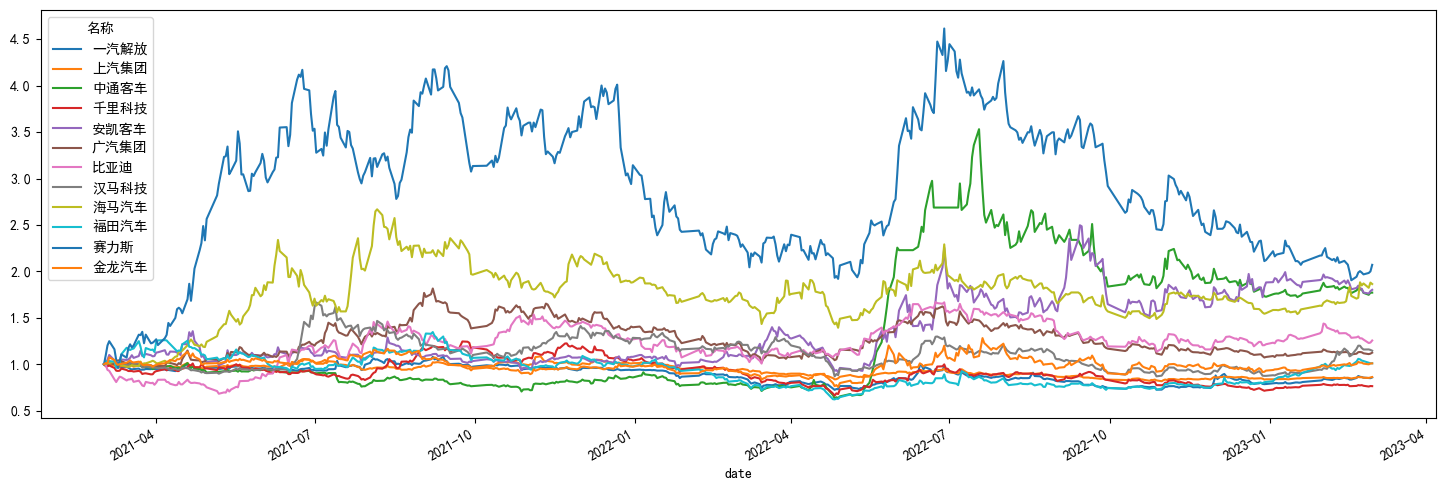

In [52]:
stock_close_div0=stock_close.div(stock_close.iloc[0,:],axis=1)
fig=plt.figure(figsize=(18,6))
stock_close_div0.plot(ax=fig.gca())

## 均值风险投资组合优化

* 标准差与半标准差

半标准差（Semi - Standard Deviation）是一种在金融领域用于衡量投资风险的指标，它重点关注投资回报低于特定目标值的波动情况。以下为你详细介绍：

定义

半标准差是仅考虑收益率低于平均值（或某个特定目标收益率）部分的标准差。传统的标准差衡量的是数据相对于均值的总体离散程度，既包含了高于均值的波动，也包含了低于均值的波动。但在投资中，投资者往往更关心资产价格下跌带来的风险，半标准差就只聚焦于这些下行波动，从而更精准地反映投资可能面临的负面风险。

计算方法

用公式表示，如果 $R_i$ 是第 $i$ 期的收益率，$R_t$ 是目标收益率，$n$ 是低于目标收益率的观测值数量，那么半标准差 $SSD$ 的计算公式为：
$$SSD = \sqrt{\frac{\sum_{i=1}^{n} \min(0, R_i - R_t)^2}{n}}$$


* port.alpha

在投资组合优化的相关代码里，`port.alpha` 通常代表着显著水平（Significance level），它在风险评估和投资组合优化过程中有着重要作用，以下为你详细介绍：

 风险度量中的应用

在风险评估方面，显著水平常用于确定风险度量指标的临界值，常见于在险价值（VaR）和条件在险价值（CVaR）的计算中。
- **在险价值（VaR）**：VaR是一种衡量在一定的置信水平和持有期内，投资组合可能遭受的最大损失的风险度量指标。`port.alpha` 所代表的显著水平与置信水平互补，即置信水平 = 1 - `port.alpha`。例如，若 `port.alpha = 0.05`，这意味着置信水平为 95%，表示在 95% 的情况下，投资组合在特定持有期内的损失不会超过计算得出的 VaR 值。
- **条件在险价值（CVaR）**：CVaR 也被称作预期损失（ES），它是在投资组合损失超过 VaR 的条件下，损失的期望值。`port.alpha` 同样用于确定 CVaR 计算中的损失分布范围，帮助投资者评估极端情况下的潜在损失。

投资组合优化中的约束条件

在投资组合优化过程中，`port.alpha` 可以作为约束条件的一部分，帮助投资者平衡风险和收益。通过设定不同的显著水平，投资者可以调整投资组合对风险的承受程度。
- **风险厌恶型投资者**：对于风险厌恶程度较高的投资者，他们可能会选择较低的 `port.alpha` 值（如 0.01 或 0.02），对应较高的置信水平（如 99% 或 98%）。这样在优化投资组合时，会更注重避免极端损失，从而选择风险较低的资产配置方案。
- **风险偏好型投资者**：风险偏好较高的投资者可能会选择较高的 `port.alpha` 值（如 0.1），对应较低的置信水平（如 90%）。这种情况下，投资组合优化会更倾向于追求较高的收益，而相对容忍一定程度的极端损失风险。

In [12]:
Y = Y_all
# 构建投资组合对象
port = rp.Portfolio(returns=Y)

# 计算最优投资组合

# 选择方法并估计输入参数：

method_mu='hist'  # 基于历史数据估计预期收益率的方法
method_cov='hist'  # 基于历史数据估计协方差矩阵的方法

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# 估计最优投资组合：
#这里将 `port.alpha` 设置为 0.05，意味着在后续使用风险度量指标（如 VaR 或 CVaR）进行投资组合优化时，会基于 95% 的置信水平来评估和控制风险。
#也就是说，投资组合的优化目标是在 95% 的置信水平下，尽量降低潜在的最大损失，同时追求合理的收益。 
#port.alpha = 0.05
model='Classic'  # 可以是 Classic（历史法）、BL（布莱克 - 利特曼模型）或 FM（因子模型）
rm = 'MSV'  # 使用的风险度量，半标准差
obj = 'Sharpe'  # 目标函数，可以是 MinRisk（最小风险）、MaxRet（最大收益）、Utility（效用）或 Sharpe（夏普比率）
hist = True  # 对于依赖情景的风险度量，使用历史情景
rf = 0  # 无风险利率
l = 0  # 风险厌恶因子，仅在目标函数为 'Utility' 时有用

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

In [11]:
w

,weights
一汽解放,1.484357e-10
上汽集团,1.065021e-10
中通客车,3.000196e-01
千里科技,1.896297e-10
安凯客车,1.629219e-01
广汽集团,4.427512e-11
比亚迪,2.049603e-10
汉马科技,1.410254e-11
海马汽车,2.982213e-01
福田汽车,1.031369e-10


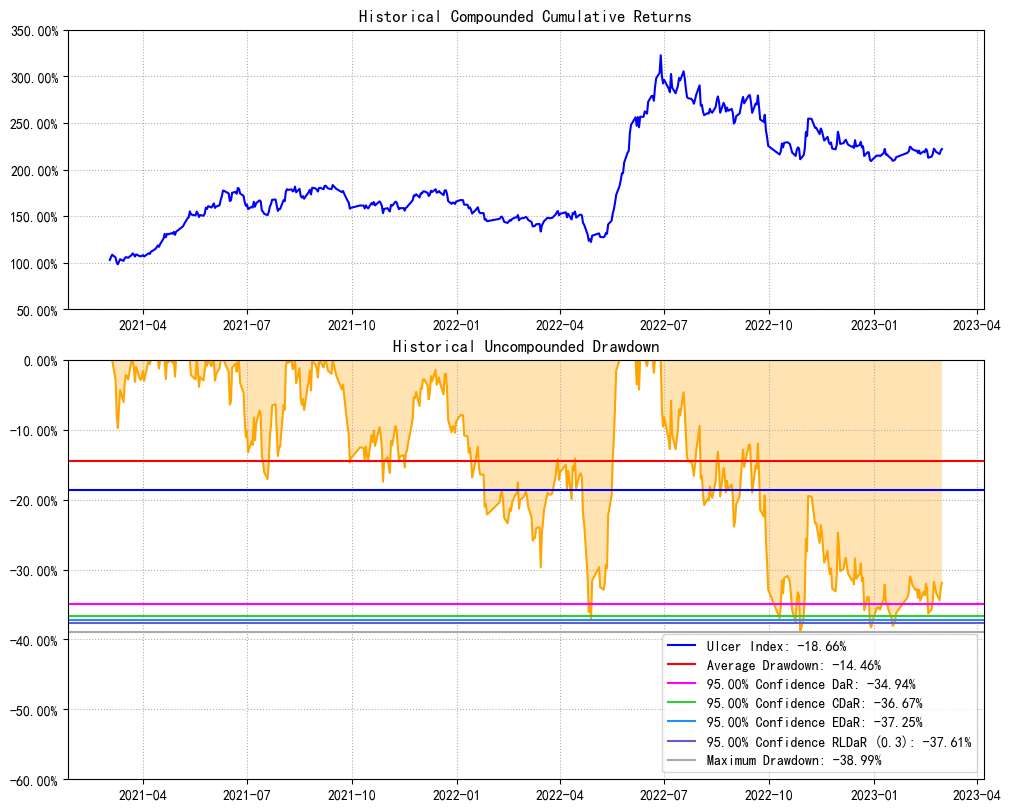

In [5]:
ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=0.05,
                      height=8,
                      width=10,
                      ax=None)

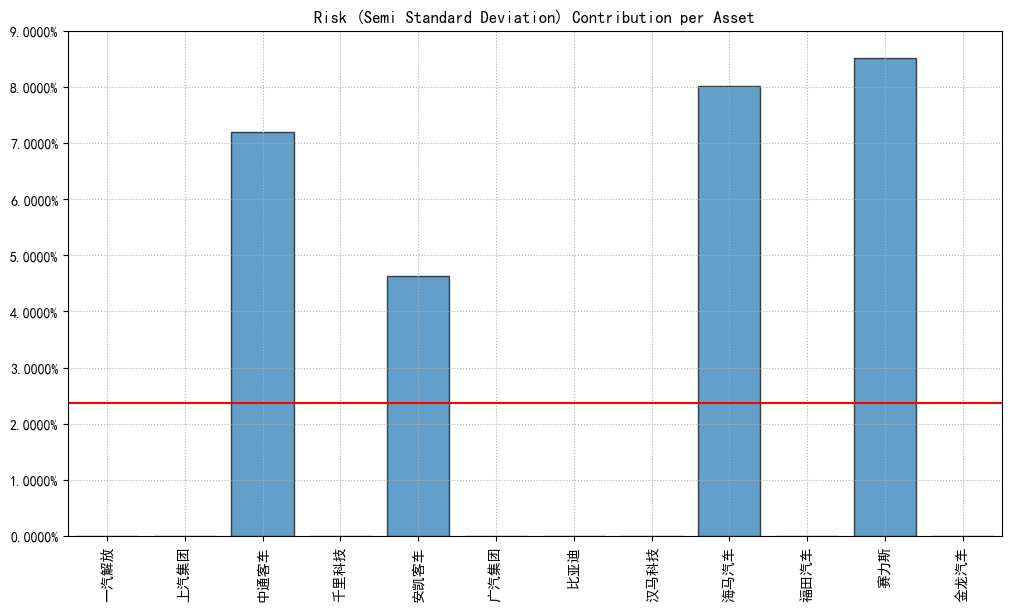

In [55]:
ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

### pybroker策略的实现

In [71]:
#假设我们希望每月初对一个只做多头的投资组合进行重新平衡，以确保投资组合中的每只股票都有大致相等的配置。
#首先，我们编写一个辅助函数，用于检测当前 K 线的日期是否为新月的开始：
# ctxs: dict[str, ExecContext] 是一个字典，键是字符串，值是ExecContext对象
def start_of_month(ctxs: dict[str, ExecContext]) -> bool:
    dt = tuple(ctxs.values())[0].dt
    if dt.month != pybroker.param('current_month'):
        pybroker.param('current_month', dt.month)
        return True
    return False

#接下来，我们实现一个函数，该函数将买入或卖出足够数量的股票，以达到目标配置。
#如果当前配置高于目标水平，该函数将卖出所需数量的资产股票；如果当前配置低于目标水平，该函数将买入所需数量的资产股票。
def set_target_shares(
    ctxs: dict[str, ExecContext],
    targets: dict[str, float]
):
    for symbol, target in targets.items():
        ctx = ctxs[symbol]
        target_shares = ctx.calc_target_shares(target)
        pos = ctx.long_pos()
        if pos is None:
            ctx.buy_shares = target_shares
        elif pos.shares < target_shares:
            ctx.buy_shares = target_shares - pos.shares
        elif pos.shares > target_shares:
            ctx.sell_shares = pos.shares - target_shares


pybroker.param('lookback', 100)  # Use past year of returns.

def calculate_returns(ctxs: dict[str, ExecContext], lookback: int):
    prices = {}
    for ctx in ctxs.values():
        prices[ctx.symbol] = ctx.close[-lookback:]
    df = pd.DataFrame(prices)
    return df.pct_change().dropna()

def optimization(ctxs: dict[str, ExecContext]):
    lookback = pybroker.param('lookback')
    if start_of_month(ctxs):
        Y = calculate_returns(ctxs, lookback)
        port = rp.Portfolio(returns=Y)
        port.assets_stats(method_mu='hist', method_cov='hist')
        w = port.optimization(
            model='Classic',
            rm='MSV',
            obj='Utility',
            rf=0,      # Risk free rate.
            l=0.2,       # Risk aversion factor.
            hist=True  # Use historical scenarios.
        )
        #print(w.T["000800"].values[0])
        targets = {
            symbol: w.T[symbol].values[0]
            for symbol in ctxs.keys()
        }
        set_target_shares(ctxs, targets)

In [72]:
strategy = Strategy(akshare, start_date='3/2/2021', end_date='3/1/2022')
strategy.add_execution(None, stock_qiche["代码"].values)
strategy.set_after_exec(optimization)
result = strategy.backtest(warmup=pybroker.param('lookback'))

Backtesting: 2021-03-02 00:00:00 to 2022-03-01 00:00:00

Loaded cached bar data.

Test split: 2021-03-02 00:00:00 to 2022-03-01 00:00:00


  0% (0 of 243) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 41% (101 of 243) |#########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (111 of 243) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 53% (131 of 243) |###########           | Elapsed Time: 0:00:00 ETA:   0:00:00
 62% (151 of 243) |#############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 70% (171 of 243) |###############       | Elapsed Time: 0:00:00 ETA:   0:00:00
 78% (191 of 243) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 86% (211 of 243) |###################   | Elapsed Time: 0:00:00 ETA:   0:00:00
 95% (231 of 243) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (243 of 243) |######################| Elapsed Time: 0:00:00 ETA:  00:00:00
100% (243 of 243) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:01


In [49]:
result.metrics_df

,name,value
0,trade_count,6.000000
1,initial_market_value,100000.000000
2,end_market_value,110601.740000
3,total_pnl,3312.140000
4,unrealized_pnl,7289.600000
5,total_return_pct,3.312140
6,total_profit,32045.400000
7,total_loss,-28733.260000
8,total_fees,0.000000
9,max_drawdown,-47819.050000


## 使用历史估计的简单风险平价组合优化

* 风险平价

在组合投资中，风险平价优化具有独特的意义和广泛的使用场景，具体如下：

* 意义

- **风险均衡分配**：风险平价策略的核心是将风险均匀地分配到投资组合中的各个资产类别上，避免投资组合的风险过度集中在某些特定资产上。这样可以降低单一资产表现不佳对整个投资组合的影响，提高投资组合的稳定性和抗风险能力。
- **优化风险调整后收益**：通过合理配置不同资产，使各资产对组合风险的贡献相对均衡，风险平价优化有助于在给定的风险水平下实现更高的收益，或者在追求相同收益目标时承担更低的风险，从而提高投资组合的风险调整后收益，如夏普比率等指标。
- **适应不同市场环境**：该策略不依赖于对特定资产的走势预测，而是基于资产之间的风险关系进行配置。因此，在不同的市场环境下，无论是牛市、熊市还是震荡市，风险平价优化都有可能通过资产间的互补性来维持投资组合的相对稳定表现，具有较强的市场适应性。

* 使用场景

- **多元化投资组合构建**：投资者希望构建一个多元化的投资组合，涵盖股票、债券、大宗商品、房地产等多种资产类别。风险平价优化可以帮助确定各类资产的合理配置比例，使得每种资产对组合风险的贡献大致相等，从而在实现多元化的同时，有效控制整体风险。例如，一个大型养老基金可能会采用风险平价策略来构建其资产组合，以确保在长期内能够稳定地实现资产增值，同时满足养老金支付的需求。
- **低风险偏好投资者**：对于风险承受能力较低、追求稳健投资收益的投资者，如保守型的个人投资者或部分保险资金等，风险平价优化提供了一种较为合适的投资策略。它通过均衡风险的方式，避免了投资组合因过度暴露于高风险资产而遭受巨大损失的可能性，在保证资产安全性的基础上，追求一定的收益增长。
- **资产配置动态调整**：随着市场行情的变化，资产的风险收益特征会发生改变，投资组合的风险结构也会随之变化。风险平价优化可以作为一种动态调整的工具，定期或不定期地根据市场情况重新评估资产的风险贡献，并调整资产配置比例，使投资组合始终保持风险平价的状态，以适应市场的动态变化，维持投资组合的稳定性和有效性。
- **对冲基金和专业投资机构**：许多对冲基金和专业投资机构将风险平价策略作为其核心投资策略之一。它们利用风险平价优化来构建复杂的投资组合，通过对不同资产的多空操作，实现对市场风险的有效管理和收益的获取。例如，一些量化对冲基金可能会结合风险平价策略与其他量化模型，在各种市场条件下寻找投资机会，以实现相对稳定的超额收益。

In [53]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

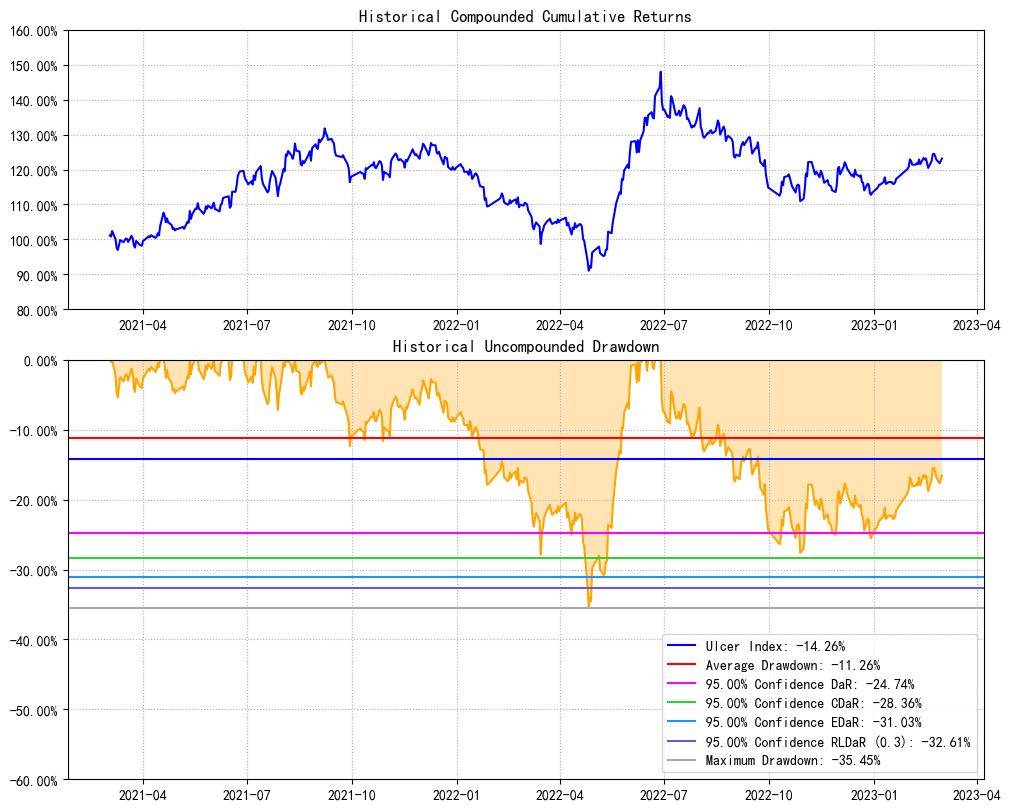

In [12]:
ax = rp.plot_drawdown(returns=Y,
                      w=w_rp,
                      alpha=0.05,
                      height=8,
                      width=10,
                      ax=None)

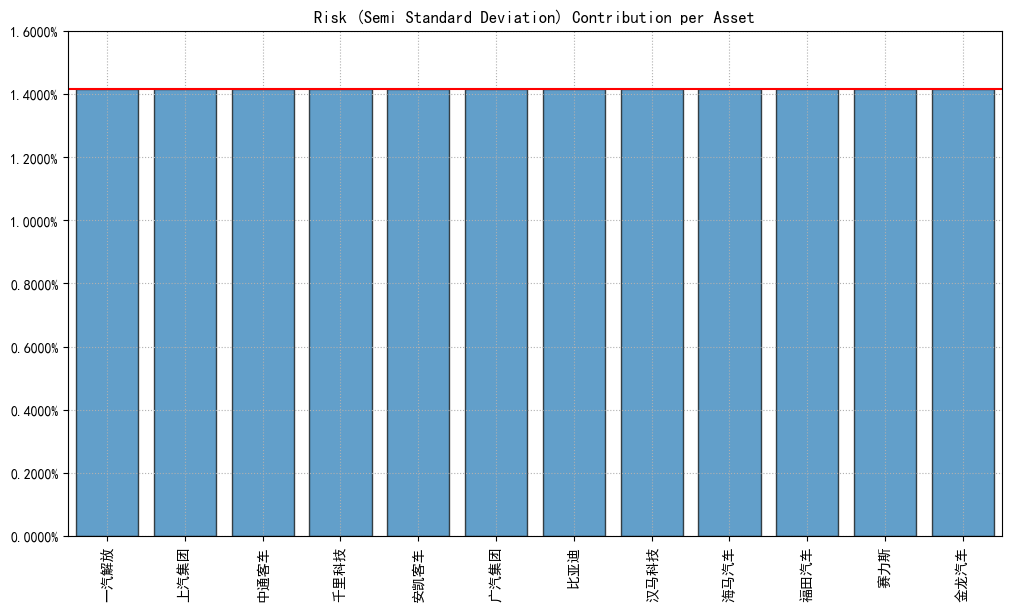

In [54]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

### 估计宽松风险平价投资组合

在这部分，我将使用该模型的A、B和C版本来计算宽松风险平价投资组合（甘贝塔和权2020年提出）。宽松风险平价是一种能够在普通风险平价模型中纳入收益约束条件的模型。

* lowerret 是该投资组合对象的一个属性，它代表的是投资组合预期收益的下限。也就是说，在后续进行投资组合优化的过程中，要求优化得到的投资组合预期收益率不能低于这个设定的值。

In [56]:
b = None  # 风险贡献约束向量
version = 'A'  # 可以是A、B或C
l = 1  # 惩罚项，仅对C版本有效

# 设置收益约束
port.lowerret = 0.001#单日收益下限?

w_rrp_a = port.rrp_optimization(model=model, version=version, l=l, b=b, hist=hist)

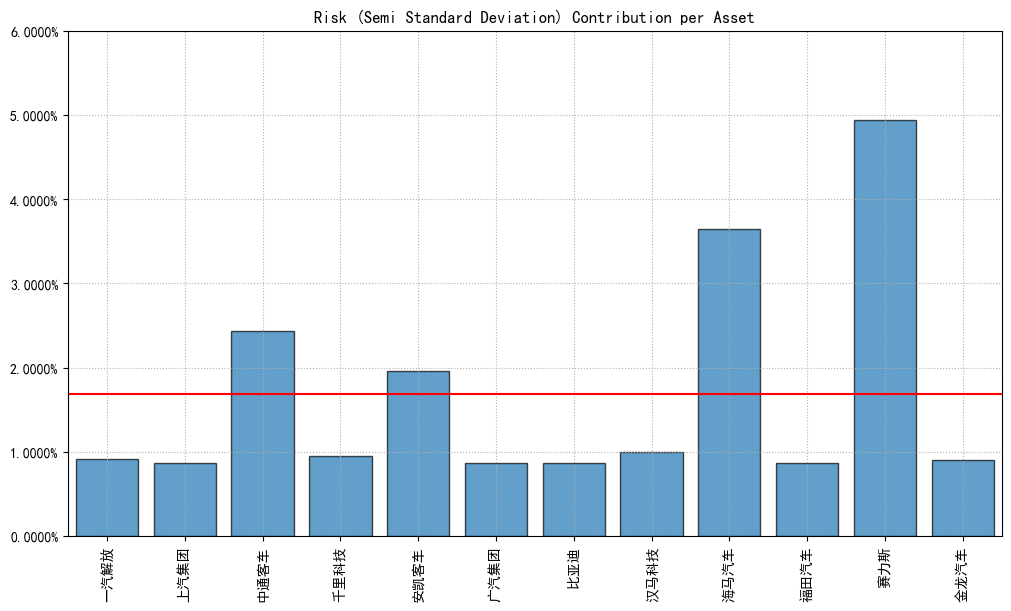

In [57]:
ax = rp.plot_risk_con(w_rrp_a, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

In [64]:
def optimization0(ctxs: dict[str, ExecContext]):
    lookback = pybroker.param('lookback')
    if start_of_month(ctxs):
        Y = calculate_returns(ctxs, lookback)
        port = rp.Portfolio(returns=Y)
        port.assets_stats(method_mu='hist', method_cov='hist')
        model="Classic"
        rm="MSV"
        rf=0
        b=None
        hist=True
        w = port.rrp_optimization(model=model, version="A", l=0, b=b, hist=hist)
        #print(w.T["000800"].values[0])
        targets = {
            symbol: w.T[symbol].values[0]
            for symbol in ctxs.keys()
        }
        set_target_shares(ctxs, targets)

In [65]:
strategy = Strategy(akshare, start_date='3/2/2021', end_date='3/1/2022')
strategy.add_execution(None, stock_qiche["代码"].values)
strategy.set_after_exec(optimization0)
result = strategy.backtest(warmup=pybroker.param('lookback'))

Backtesting: 2021-03-02 00:00:00 to 2022-03-01 00:00:00

Loaded cached bar data.

Test split: 2021-03-02 00:00:00 to 2022-03-01 00:00:00


  0% (0 of 243) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 41% (101 of 243) |#########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (111 of 243) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 49% (121 of 243) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 53% (131 of 243) |###########           | Elapsed Time: 0:00:00 ETA:   0:00:00
 62% (151 of 243) |#############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 66% (161 of 243) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 70% (171 of 243) |###############       | Elapsed Time: 0:00:00 ETA:   0:00:00
 78% (191 of 243) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 86% (211 of 243) |###################   | Elapsed Time: 0:00:01 ETA:   0:00:00
 95% (231 of 243) |####################  | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (243 of 243) |######################| Elapsed Time: 0:00:01 ETA:  00:00:00
100% (243 of 243) |#####################


Finished backtest: 0:00:01


In [66]:
result.metrics_df

,name,value
0,trade_count,44.000000
1,initial_market_value,100000.000000
2,end_market_value,96717.940000
3,total_pnl,5463.120000
4,unrealized_pnl,-8745.180000
5,total_return_pct,5.463120
6,total_profit,6121.960000
7,total_loss,-658.840000
8,total_fees,0.000000
9,max_drawdown,-23105.430000


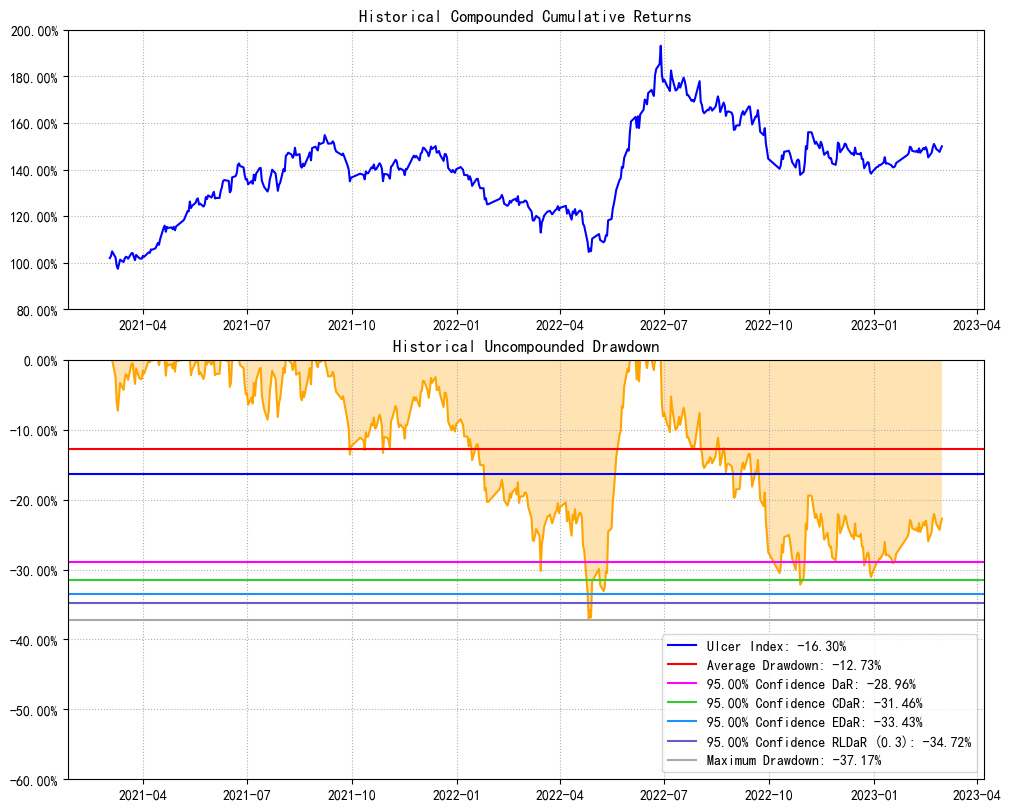

In [25]:
ax = rp.plot_drawdown(returns=Y,
                      w=w_rrp_a,
                      alpha=0.05,
                      height=8,
                      width=10,
                      ax=None)

## 分层聚类组合优化

https://www.wuzao.com/document/riskfolio-lib/hcportfolio.html

https://www.yuque.com/wangpeng-lucdx/kb/hq7gdmzyu1d2tlf3?singleDoc# 《投资组合优化函数模块》

### rp.plot_clusters  可视化

`rp.plot_clusters` 是 `riskfolio` 库中的一个函数，用于基于选定的相关性度量创建聚类图。以下从功能、参数、用途和意义等方面为你详细介绍：

* 功能概述

该函数能够对资产收益率数据进行聚类分析，并将聚类结果以可视化的方式呈现出来。通过聚类图，投资者可以直观地看到资产之间的相关性和相似性，了解哪些资产倾向于聚为一类，进而辅助投资决策，如资产配置、风险分散等。

* 参数说明

- **`returns`**：这是一个 `DataFrame` 类型的资产收益率数据，是聚类分析的基础，包含了不同资产在各个时间点的收益率信息。
- **`custom_cov`**：自定义协方差矩阵，当 `codependence` 参数值为 `'custom_cov'` 时使用，默认值为 `None`。
- **`codependence`**：用于构建距离度量和聚类的相关性或相似性矩阵，有多种可选值，如 `'pearson'`（皮尔逊相关矩阵）、`'spearman'`（斯皮尔曼相关矩阵）等，默认值为 `'pearson'`。不同的相关性度量方式会影响聚类的结果。
- **`linkage`**：层次聚类的连接方法，如 `'ward'`、`'single'`、`'complete'` 等，默认值为 `'ward'`。不同的连接方法决定了聚类过程中如何合并聚类，会对最终的聚类结构产生影响。
- **`k`**：聚类数，该值将取代通过双差异间隙统计量计算出的最优聚类数，默认值为 `None`。
- **`max_k`**：双差异间隙统计量用于寻找最优聚类数时使用的最大聚类数，默认值为 10。
- **`bins_info`**：用于计算变异信息的箱数，有多种选择，如 `'KN'`（克努特选择法）、`'FD'`（弗里德曼 - 迪亚科尼斯选择法）等，默认值为 `'KN'`。
- **`alpha_tail`**：下尾相依指数的显著性水平，默认值为 0.05。
- **`gs_threshold`**：格伯统计量阈值，默认值为 0.5。
- **`leaf_order`**：布尔值，指示聚类是否按顺序排列，以使连续叶节点之间的距离最小，默认值为 `True`。
- **`show_clusters`**：布尔值，指示是否绘制聚类，默认值为 `True`。
- **`dendrogram`**：布尔值，指示绘图是否有树形图，默认值为 `True`。
- **`cmap`**：用于绘制 `pcolormesh` 图的颜色映射，默认值为 `'RdYlBu'`。
- **`linecolor`**：用于在 `pcolormesh` 图中识别聚类的颜色，默认值为 `'fuchsia'`。
- **`title`**：图表的标题，默认值为 `''`。
- **`height`**：图像的高度（英寸），默认值为 12。
- **`width`**：图像的宽度（英寸），默认值为 12。
- **`ax`**：如果提供，则在该轴上绘制，默认值为 `None`。


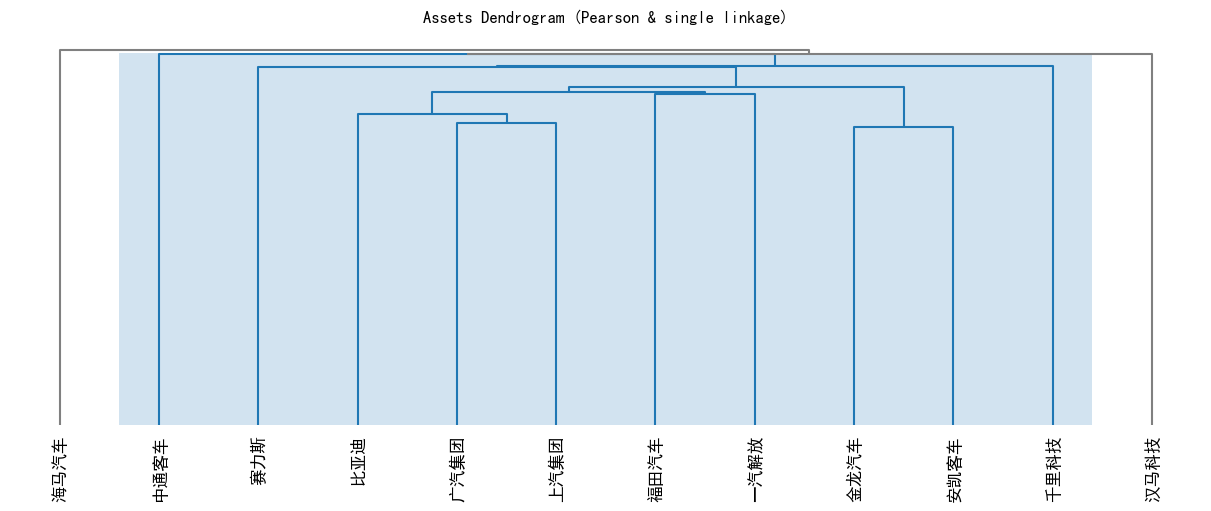

In [ ]:
ax = rp.plot_dendrogram(returns=Y,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

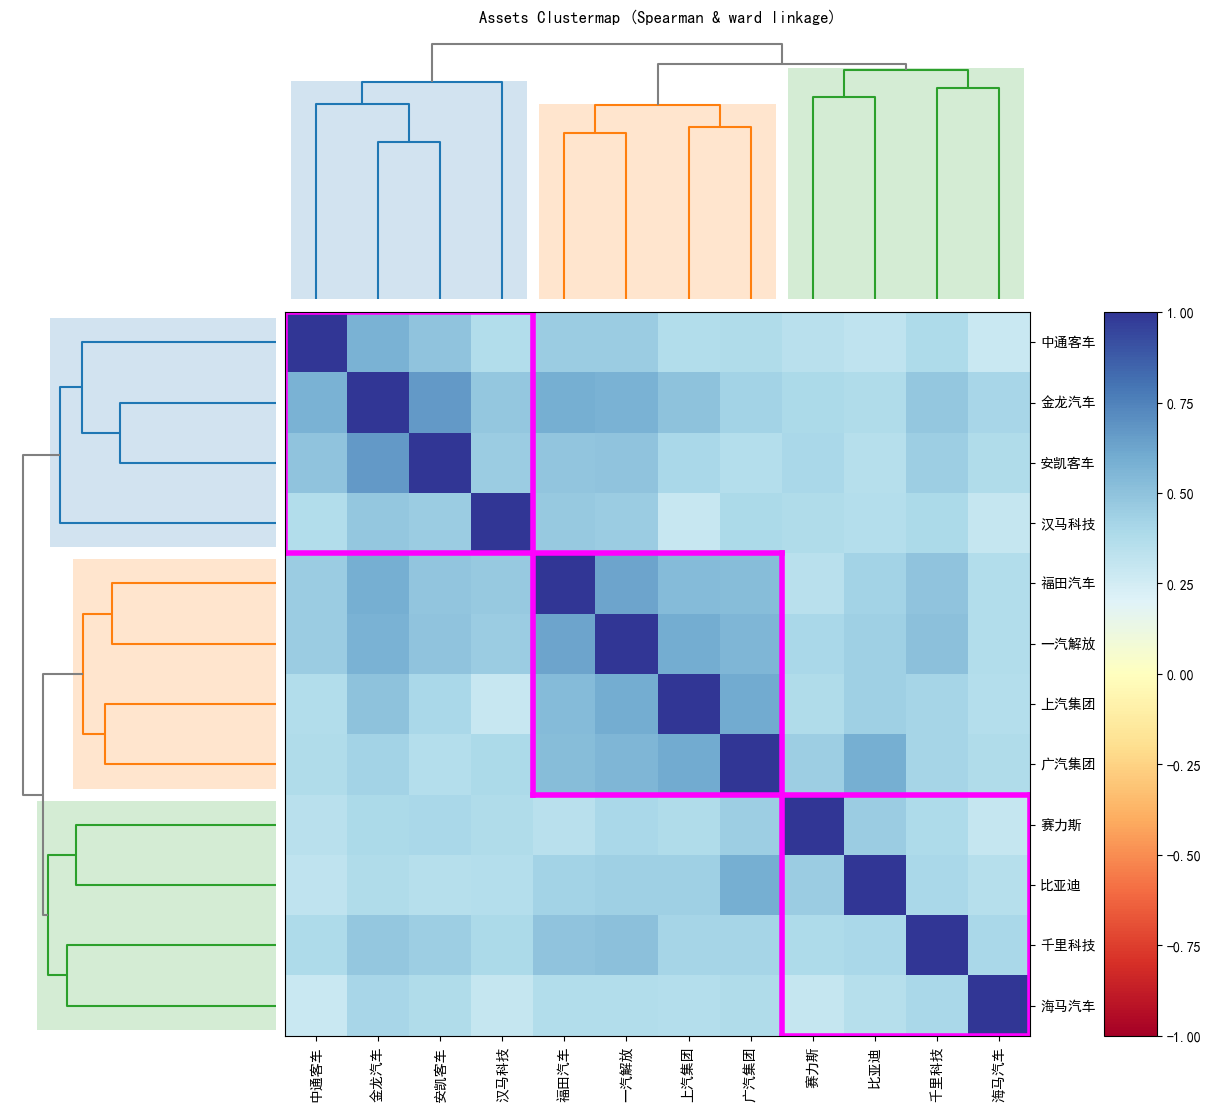

In [28]:
ax = rp.plot_clusters(returns=Y,
                      codependence='spearman',
                      linkage='ward',
                      k=None,
                      max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      ax=None)

## 优化方法

1. **理论介绍**：Riskfolio-Lib可运用多种机器学习资产配置模型，主要有分层风险平价（HRP）、分层均等风险贡献（HERC）、嵌套聚类优化（NCO）。前两者能选用32种风险度量计算组合，涵盖分散性、下行、回撤风险度量等类别；NCO模型则有四个目标函数，各对应不同风险措施。
2. **模块函数**
    - **HCPortfolio类**：用于创建包含计算最优投资组合所需属性的投资组合对象。参数众多，`returns`代表资产收益数据；`alpha`等与各类风险度量的显著性水平相关；`solver_rl`和`solvers`涉及计算风险度量时使用的求解器；`w_max`和`w_min`是分层风险平价权重的上下界约束 。
    - **optimization方法**：依据用户选择的优化模型计算最优投资组合。`model`可选择不同的分层聚类投资组合模型；`codependence`用于指定构建距离度量和聚类的相关性矩阵类型；`covariance`决定估计协方差矩阵的方法；`obj`是NCO模型的目标函数；`rm`为优化投资组合所使用的风险度量。 

In [68]:
# 构建投资组合对象
port = rp.HCPortfolio(returns=Y)

# 估计最优投资组合：

model='HRP'  # 可以是 HRP 或 HERC
codependence = 'pearson'  # 用于在聚类中对资产进行分组的相关矩阵
rm = 'MV'  # 使用的风险度量，此次将使用方差
rf = 0  # 无风险利率
linkage = 'single'  # 用于构建聚类的链接方法
max_k = 10  # 仅适用于 HERC 模型，在双差异间隙统计中使用的最大聚类数
leaf_order = True  # 考虑树状图中叶子节点的最优顺序

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

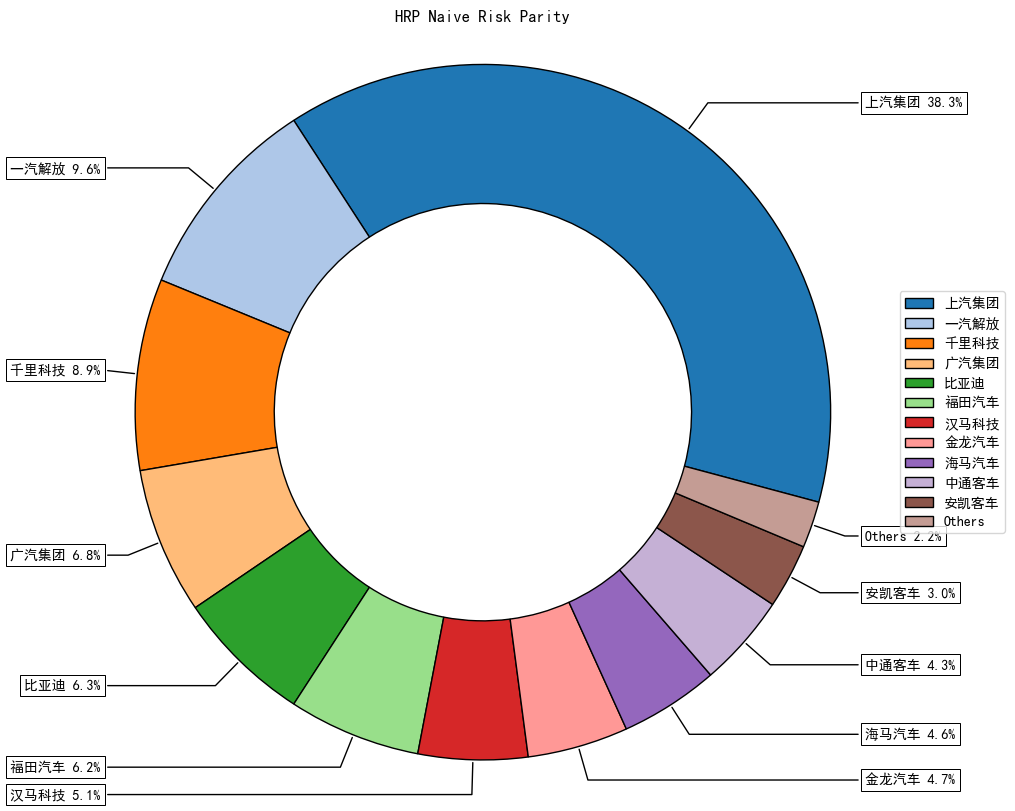

In [69]:
wax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

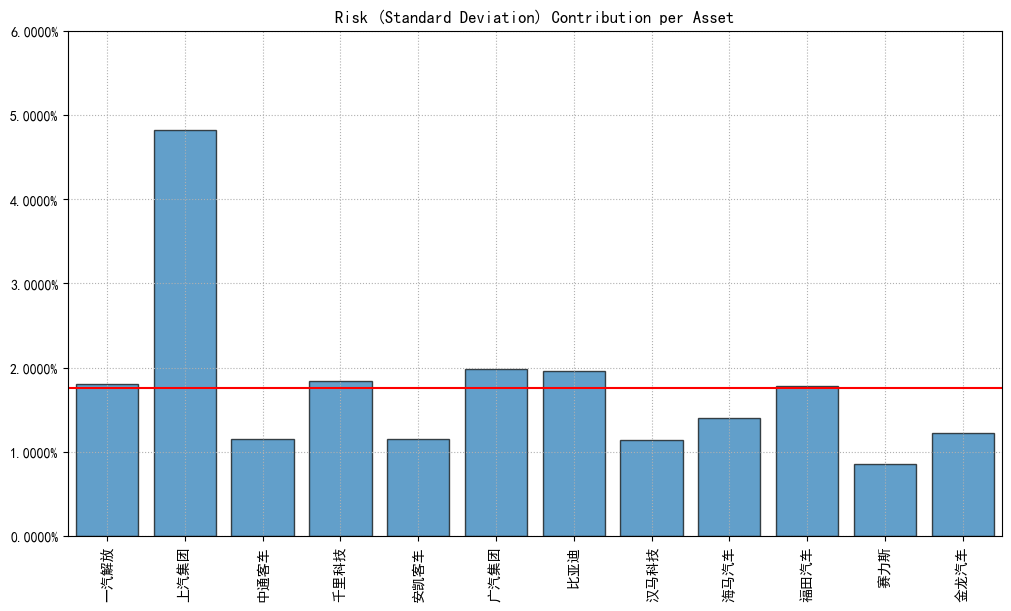

In [70]:
mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)